In [13]:
import torch
import torch.nn as nn
import torch.optim as o
import torch.distributions as d

device = None
# device = "cuda" if torch.cuda.is_available() else "cpu"

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from tqdm.auto import trange
from ipywidgets import Output
from IPython.display import clear_output, display

In [14]:
# TODO: Define 57 distribution

class Uniform(d.Uniform):
    def log_prob(self, value):
        mask = torch.flatten((self.low < value) & (value < self.high), -self.low.ndim).all(-1)
        log_probs = torch.empty(mask.size()).fill_(-torch.inf)
        log_probs[mask] = super().log_prob(value[mask]).flatten(-self.low.ndim).sum(-1)
        return log_probs

class Normal(d.Normal):
    def log_prob(self, value):
        return super().log_prob(value).flatten(-self.loc.ndim).sum(-1)

In [15]:
def gmm(locs, scales=None, probs=None) -> d.Distribution:
    if scales is None:
        scales = torch.ones_like(locs)
    if probs is None:
        probs = torch.ones(locs.size(0))
    mix = d.Categorical(probs)
    comp = d.Independent(d.Normal(locs, scales), 1)
    return d.MixtureSameFamily(mix, comp)

def cost(x1: torch.Tensor, x2: torch.Tensor, p: float = 2.):
    return torch.norm(x1 - x2, p, dim=1) ** p

def get_prob(distribution):
    def get(tensor):
        return distribution.log_prob(tensor).exp_()
    return get

def apply_critic(critic):
    @torch.no_grad()
    def apply(tensor):
        return critic(tensor)
    return apply

In [16]:
def plot_grid(func, xlim=None, ylim=None, n_pixels=50,
              colorbar=False, colorbar_label=None, **imshow_kwargs):
    ylim = ylim or xlim or plt.gca().get_ylim()
    xlim = xlim or plt.gca().get_xlim()
    mesh = torch.meshgrid(torch.linspace(*xlim, n_pixels),
                          torch.linspace(*ylim, n_pixels), indexing="xy")
    grid = func(torch.dstack(mesh)).numpy()
    dx = .5 * (xlim[1] - xlim[0]) / (n_pixels - 1)
    dy = .5 * (ylim[1] - ylim[0]) / (n_pixels - 1)
    extent = (xlim[0] - dx, xlim[1] + dx, ylim[0] - dy, ylim[1] + dy)
    plt.imshow(grid[::-1, :], extent=extent, **imshow_kwargs)
    if colorbar:
        plt.colorbar(label=colorbar_label)

@torch.no_grad()
def plot_transform(samples, moved_samples):
    x, y = samples.cpu().numpy().T
    dx, dy = (moved_samples - samples).cpu().numpy().T
    plt.quiver(x, y, dx, dy, angles='xy', scale_units='xy', scale=1., width=.0025)


In [31]:
critic = nn.Sequential(
    nn.Linear(2, 16), nn.LeakyReLU(),
    nn.Linear(16, 16), nn.LeakyReLU(),
    nn.Linear(16, 16), nn.LeakyReLU(),
    nn.Linear(16, 1), nn.Tanh()
).to(device)

mover = nn.Sequential(
    nn.Linear(2, 16), nn.LeakyReLU(),
    nn.Linear(16, 16), nn.LeakyReLU(),
    nn.Linear(16, 16), nn.LeakyReLU(),
    nn.Linear(16, 2)
).to(device)

optimizer_params = dict(lr=1e-4, betas=(.0, .9))

critic_opt = o.Adam(critic.parameters(), **optimizer_params)
mover_opt = o.Adam(mover.parameters(), **optimizer_params)


In [27]:
def train(critic, mover, source, target, l,
          n_iter, n_mover_iter, n_samples,
          plot_interval, n_arrows=None):
    n_arrows = n_arrows or n_samples // 4
    plt.figure(figsize=(13, 5))
    plt.subplot(1, 2, 1, title="Source distribution")
    plot_grid(get_prob(source), (-4, 4), colorbar=True, colorbar_label="density")
    plt.subplot(1, 2, 2, title="Target distribution")
    plot_grid(get_prob(target), (-4, 4), colorbar=True, colorbar_label="density")
    plt.show()
    progress_widget = trange(n_iter)
    plot_widget = Output()
    display(plot_widget)

    def plot_step(x, y, h_x):
        plt.figure(figsize=(12, 10))
        plt.scatter(*x.detach().cpu().numpy().T,
                    color="blue", label="Source samples", alpha=.5)
        plt.scatter(*y.detach().cpu().numpy().T,
                    color="green", label="Target samples", alpha=.5)
        plt.scatter(*h_x.detach().cpu().numpy().T,
                    color="purple", label="Moved samples", alpha=.5)
        plot_transform(x[:n_arrows], h_x[:n_arrows])
        plot_grid(apply_critic(critic), alpha=.5, cmap=cm.PRGn,
                    colorbar=True, colorbar_label="Critic output")
        plt.legend(loc="upper left")
        plt.show(block=False)

    
    try:
        for step in progress_widget:
            x = source.sample((n_samples,)).to(device)
            y = target.sample((n_samples,)).to(device)

            for _ in range(n_mover_iter):
                h_x = mover(x)
                mover_opt.zero_grad()
                mover_loss = l * cost(x, h_x).mean() - critic(h_x).mean()
                mover_loss.backward()
                mover_opt.step()

            critic_opt.zero_grad()
            critic_loss = critic(h_x.detach()).mean() - critic(y).mean()
            critic_loss.backward()
            critic_opt.step()

            with torch.no_grad():
                loss = critic(y).mean() + l * cost(x, h_x).mean() - critic(h_x).mean()
                progress_widget.set_postfix({"loss": loss.item()})

            if step % plot_interval == 0:
                with plot_widget:
                    try:
                        clear_output(wait=True)
                        plot_step(x, y, h_x)
                    except KeyboardInterrupt:
                        break
        plot_widget.close()
        plot_step(x, y, h_x)
    except KeyboardInterrupt:
        pass

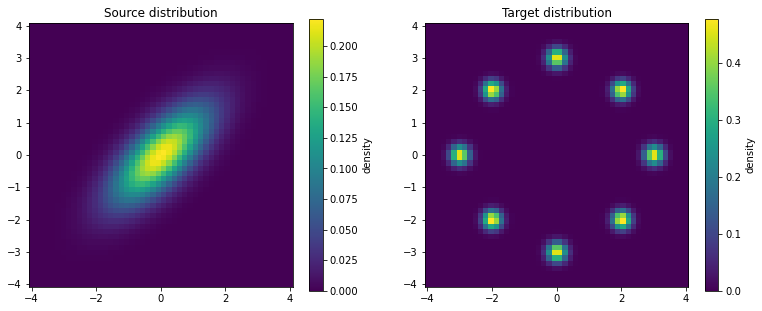

  0%|          | 0/1000 [00:00<?, ?it/s]

Output()

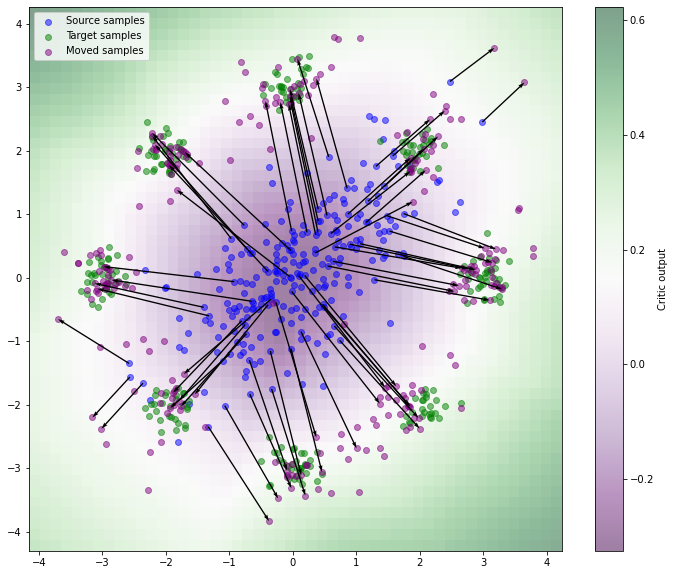

In [29]:
source = d.MultivariateNormal(torch.zeros(2), torch.tensor([[1., -.7], [.7, 1.]]))
target = gmm(torch.tensor([[ 3.,  0.], [ 0.,  3.], [-3.,  0.], [ 0., -3.],
                           [ 2.,  2.], [ 2., -2.], [-2.,  2.], [-2., -2.]]),
             .2 * torch.ones(8, 2))

train(critic, mover, source, target,
      l=.05,
      n_iter=2000,
      n_mover_iter=25,
      n_samples=256,
      plot_interval=25)

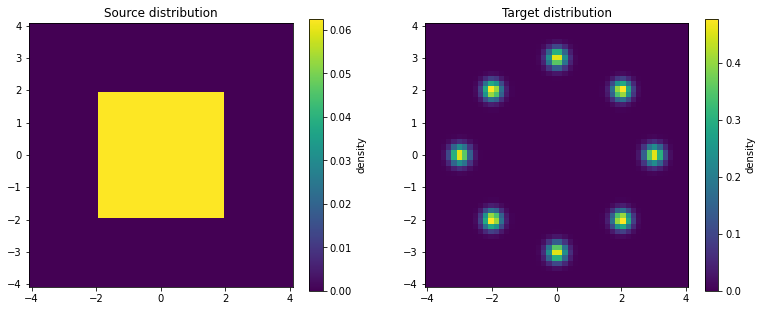

  0%|          | 0/2000 [00:00<?, ?it/s]

Output()

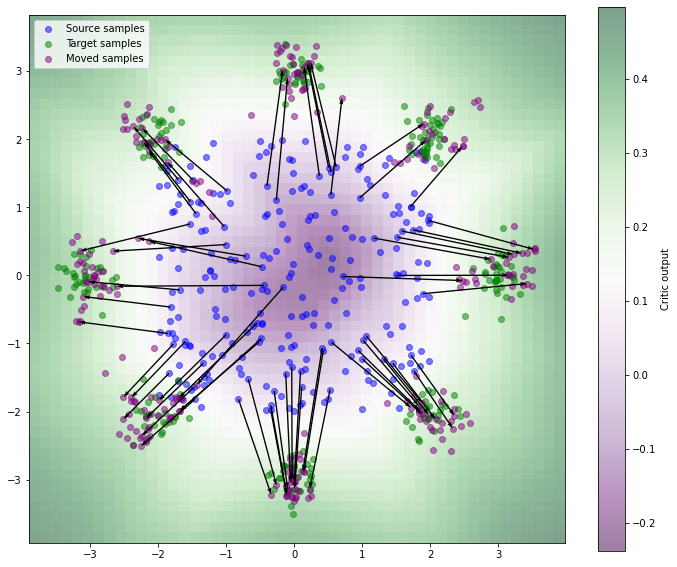

In [32]:
source = Uniform(-2 * torch.ones(2), 2 * torch.ones(2))
target = gmm(torch.tensor([[ 3.,  0.], [ 0.,  3.], [-3.,  0.], [ 0., -3.],
                           [ 2.,  2.], [ 2., -2.], [-2.,  2.], [-2., -2.]]),
             .2 * torch.ones(8, 2))

train(critic, mover, source, target,
      l=.05,
      n_iter=2000,
      n_mover_iter=25,
      n_samples=256,
      plot_interval=50)